# Goal

Can a classification model determine if a wine is white or red?

Now that we've determined XGBoost is the best tool for our classification problem (see Model Selection), can we improve our XGBoost model to be an even better classification model for our data?

In [1]:
# Imports

# Data import and manipulation
import pandas as pd

# Math
import numpy as np
# Seeding the whole notebook (although in general I also always set my random
# state manually when it is an option)
np.random.seed(543)

# Some statistics, including some checks for normality and skew
from scipy import stats
from scipy.stats import norm, skew

# Create a train-test split, so we reserve some data for testing
from sklearn.model_selection import train_test_split

# Visualization
import matplotlib.pyplot as plt
%matplotlib inline
# Prettier visualizations
import seaborn as sns
# Sets the default style for seaborn, adding the nice darkgrid background
sns.set()

In [2]:
# Reading the csv, which already has an index column
df = pd.read_csv("wine-data/winemag-data-130k-v2.csv", index_col=0)

In [3]:
df.head()

,country,description,designation,points,price,province,region_1,region_2,taster_name,taster_twitter_handle,title,variety,winery
0,Italy,"Aromas include tropical fruit, broom, brimston...",Vulkà Bianco,87,NaN,Sicily & Sardinia,Etna,NaN,Kerin O’Keefe,@kerinokeefe,Nicosia 2013 Vulkà Bianco (Etna),White Blend,Nicosia
1,Portugal,"This is ripe and fruity, a wine that is smooth...",Avidagos,87,15.0,Douro,NaN,NaN,Roger Voss,@vossroger,Quinta dos Avidagos 2011 Avidagos Red (Douro),Portuguese Red,Quinta dos Avidagos
2,US,"Tart and snappy, the flavors of lime flesh and...",NaN,87,14.0,Oregon,Willamette Valley,Willamette Valley,Paul Gregutt,@paulgwine,Rainstorm 2013 Pinot Gris (Willamette Valley),Pinot Gris,Rainstorm
3,US,"Pineapple rind, lemon pith and orange blossom ...",Reserve Late Harvest,87,13.0,Michigan,Lake Michigan Shore,NaN,Alexander Peartree,NaN,St. Julian 2013 Reserve Late Harvest Riesling ...,Riesling,St. Julian
4,US,"Much like the regular bottling from 2012, this...",Vintner's Reserve Wild Child Block,87,65.0,Oregon,Willamette Valley,Willamette Valley,Paul Gregutt,@paulgwine,Sweet Cheeks 2012 Vintner's Reserve Wild Child...,Pinot Noir,Sweet Cheeks


Data in the description and designation columns are going to give away what kind of wine it is in many cases. We also are not interested in details about the taster of the wine. Additionally, the region information has a lot of variety but does not give us that much more data than country, province and winery. Thus, we'll remove those columns, as well as the title for each wine, and leave only columns that we hope will work as potential predicters of variety.

In [4]:
data = df.drop(columns=["description", "designation", "region_1", "region_2",
                        "taster_name", "taster_twitter_handle", "title"])

### Exploring the Data

In [5]:
data.head()

,country,points,price,province,variety,winery
0,Italy,87,NaN,Sicily & Sardinia,White Blend,Nicosia
1,Portugal,87,15.0,Douro,Portuguese Red,Quinta dos Avidagos
2,US,87,14.0,Oregon,Pinot Gris,Rainstorm
3,US,87,13.0,Michigan,Riesling,St. Julian
4,US,87,65.0,Oregon,Pinot Noir,Sweet Cheeks


In [6]:
data.describe()

,points,price
count,129971.000000,120975.000000
mean,88.447138,35.363389
std,3.039730,41.022218
min,80.000000,4.000000
25%,86.000000,17.000000
50%,88.000000,25.000000
75%,91.000000,42.000000
max,100.000000,3300.000000


In [7]:
data.shape

(129971, 6)

In [8]:
# Checking for nulls
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 129971 entries, 0 to 129970
Data columns (total 6 columns):
country     129908 non-null object
points      129971 non-null int64
price       120975 non-null float64
province    129908 non-null object
variety     129970 non-null object
winery      129971 non-null object
dtypes: float64(1), int64(1), object(4)
memory usage: 6.9+ MB


In [9]:
len(set(data["variety"]))

708

In [10]:
# Since the top 30 varieties account for more than 80% of our data,
# let's only use observations where the variety is one of those,
# to make it easier to create our target variable, red/white
top_30_variety_counts = data["variety"].value_counts()[:30]
top_30_variety_counts.sum()

105154

In [11]:
top_30_varieties = list(top_30_variety_counts.index)
print(top_30_varieties)

['Pinot Noir', 'Chardonnay', 'Cabernet Sauvignon', 'Red Blend', 'Bordeaux-style Red Blend', 'Riesling', 'Sauvignon Blanc', 'Syrah', 'Rosé', 'Merlot', 'Nebbiolo', 'Zinfandel', 'Sangiovese', 'Malbec', 'Portuguese Red', 'White Blend', 'Sparkling Blend', 'Tempranillo', 'Rhône-style Red Blend', 'Pinot Gris', 'Champagne Blend', 'Cabernet Franc', 'Grüner Veltliner', 'Portuguese White', 'Bordeaux-style White Blend', 'Pinot Grigio', 'Gamay', 'Gewürztraminer', 'Viognier', 'Shiraz']


In [12]:
# Now, let's make our data just those where the variety is one of the top 30
data = data[data["variety"].isin(top_30_varieties)]

In [13]:
data.head()

,country,points,price,province,variety,winery
0,Italy,87,NaN,Sicily & Sardinia,White Blend,Nicosia
1,Portugal,87,15.0,Douro,Portuguese Red,Quinta dos Avidagos
2,US,87,14.0,Oregon,Pinot Gris,Rainstorm
3,US,87,13.0,Michigan,Riesling,St. Julian
4,US,87,65.0,Oregon,Pinot Noir,Sweet Cheeks


In [14]:
# I made the color dictionary by hand for this, to make it easier to see
# which wines are in which category here
# For the curious, I'm considering a Rose a white for simplicity
color = {"red": ["Pinot Noir", "Cabernet Sauvignon", "Red Blend",
                 "Bordeaux-style Red Blend", "Syrah", "Merlot", "Nebbiolo",
                 "Zinfandel", "Sangiovese", "Malbec", "Portuguese Red",
                 "Tempranillo", "Rhône-style Red Blend", "Cabernet Franc",
                 "Gamay", "Shiraz"],
         "white": ["Chardonnay", "Riesling", "Sauvignon Blanc", "Rosé",
                   "White Blend", "Sparkling Blend", "Pinot Gris",
                   "Champagne Blend", "Grüner Veltliner", "Portuguese White",
                   "Bordeaux-style White Blend", "Pinot Grigio",
                   "Gewürztraminer", "Viognier"]}

In [15]:
print(color["red"])
print(color["white"])

['Pinot Noir', 'Cabernet Sauvignon', 'Red Blend', 'Bordeaux-style Red Blend', 'Syrah', 'Merlot', 'Nebbiolo', 'Zinfandel', 'Sangiovese', 'Malbec', 'Portuguese Red', 'Tempranillo', 'Rhône-style Red Blend', 'Cabernet Franc', 'Gamay', 'Shiraz']
['Chardonnay', 'Riesling', 'Sauvignon Blanc', 'Rosé', 'White Blend', 'Sparkling Blend', 'Pinot Gris', 'Champagne Blend', 'Grüner Veltliner', 'Portuguese White', 'Bordeaux-style White Blend', 'Pinot Grigio', 'Gewürztraminer', 'Viognier']


In [16]:
# Creating our new target column, color
def find_color(variety):
    if variety in color["red"]:
        var_color = "red"
    elif variety in color["white"]:
        var_color = "white"
    else:
        var_color = "whoops"
    return var_color
data["color"] = df["variety"].map(lambda x: find_color(x))

In [17]:
# Dropping our variety column, since we no longer need it
data = data.drop(columns="variety")

In [18]:
data.head()

,country,points,price,province,winery,color
0,Italy,87,NaN,Sicily & Sardinia,Nicosia,white
1,Portugal,87,15.0,Douro,Quinta dos Avidagos,red
2,US,87,14.0,Oregon,Rainstorm,white
3,US,87,13.0,Michigan,St. Julian,white
4,US,87,65.0,Oregon,Sweet Cheeks,red


In [19]:
# Our classes are unbalanced, something we should keep in mind later
data["color"].value_counts()

red      65687
white    39467
Name: color, dtype: int64

In [20]:
# Now let's look at our NaNs and datatypes
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 105154 entries, 0 to 129970
Data columns (total 6 columns):
country     105114 non-null object
points      105154 non-null int64
price       98166 non-null float64
province    105114 non-null object
winery      105154 non-null object
color       105154 non-null object
dtypes: float64(1), int64(1), object(4)
memory usage: 5.6+ MB


In [21]:
# First things first, let's deal with our nulls
# Only 40 entries, out of over 100,000, are missing country/province data
# So I will drop those, rather than guessing or looking up the winery by hand

data["country"].isna().sum()

40

In [22]:
data.dropna(subset=["country","province"], inplace=True)

In [23]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 105114 entries, 0 to 129970
Data columns (total 6 columns):
country     105114 non-null object
points      105114 non-null int64
price       98130 non-null float64
province    105114 non-null object
winery      105114 non-null object
color       105114 non-null object
dtypes: float64(1), int64(1), object(4)
memory usage: 5.6+ MB


In [24]:
# We still have a lot of nulls in our price column.
# Rather than removing all of those values, I'll create a new column to track
# which observations were missing price data, then fill the nulls

data['price_missing'] = np.where(np.isnan(data['price']) == True, 1, 0)

In [25]:
# Checking what seems more reasonable, median or mean - median wins
# Mean is more affected by the outliers in our data, which there are several
print(data["price"].median())
print(data["price"].mean())

27.0
36.71797615408132


In [26]:
# Replacing nulls with median price
clean_data = data.copy()
clean_data["price"].fillna(clean_data["price"].median(), inplace=True)

In [27]:
clean_data.head()

,country,points,price,province,winery,color,price_missing
0,Italy,87,27.0,Sicily & Sardinia,Nicosia,white,1
1,Portugal,87,15.0,Douro,Quinta dos Avidagos,red,0
2,US,87,14.0,Oregon,Rainstorm,white,0
3,US,87,13.0,Michigan,St. Julian,white,0
4,US,87,65.0,Oregon,Sweet Cheeks,red,0


In [28]:
# Yay, no more nulls!
clean_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 105114 entries, 0 to 129970
Data columns (total 7 columns):
country          105114 non-null object
points           105114 non-null int64
price            105114 non-null float64
province         105114 non-null object
winery           105114 non-null object
color            105114 non-null object
price_missing    105114 non-null int64
dtypes: float64(1), int64(2), object(4)
memory usage: 6.4+ MB


In [29]:
# Our top 10 countries account for more than 95% of our cleaned up, no-null
# data, so let's start with those to build our model
top_10_countries = clean_data["country"].value_counts()[:10]
top_10_countries.sum()

101085

In [30]:
top_10_countries = list(top_10_countries.index)
# Now, let's make our data just those where the variety is one of the top 30
clean_data = clean_data[clean_data["country"].isin(top_10_countries)]

## Further Data Cleaning

In [31]:
clean_data.head()

,country,points,price,province,winery,color,price_missing
0,Italy,87,27.0,Sicily & Sardinia,Nicosia,white,1
1,Portugal,87,15.0,Douro,Quinta dos Avidagos,red,0
2,US,87,14.0,Oregon,Rainstorm,white,0
3,US,87,13.0,Michigan,St. Julian,white,0
4,US,87,65.0,Oregon,Sweet Cheeks,red,0


In [32]:
# Let's go ahead and once again take out our target variable, color
y = clean_data["color"]
clean_data.drop(columns="color", inplace=True)

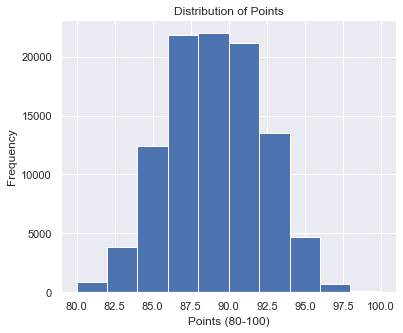

In [33]:
# Checking out the distribution of our 'points' variable - fairly normal
plt.figure(figsize=(6,5))
plt.hist(clean_data["points"])
plt.title("Distribution of Points")
plt.xlabel("Points (80-100)")
plt.ylabel("Frequency")
plt.show()

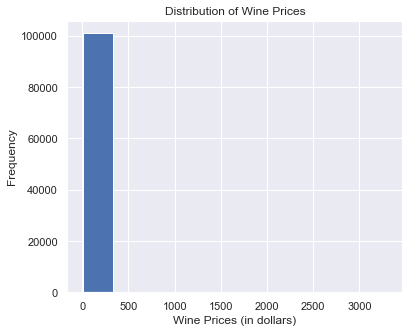

In [34]:
# Checking out the distribution of our 'price' variable - not normal at all!
plt.figure(figsize=(6,5))
plt.hist(clean_data["price"])
plt.title("Distribution of Wine Prices")
plt.xlabel("Wine Prices (in dollars)")
plt.ylabel("Frequency")
plt.show()

In [35]:
logged_data = clean_data.copy()
logged_data["log_price"] = np.log1p(logged_data["price"])

In [36]:
logged_data.head()

,country,points,price,province,winery,price_missing,log_price
0,Italy,87,27.0,Sicily & Sardinia,Nicosia,1,3.332205
1,Portugal,87,15.0,Douro,Quinta dos Avidagos,0,2.772589
2,US,87,14.0,Oregon,Rainstorm,0,2.708050
3,US,87,13.0,Michigan,St. Julian,0,2.639057
4,US,87,65.0,Oregon,Sweet Cheeks,0,4.189655


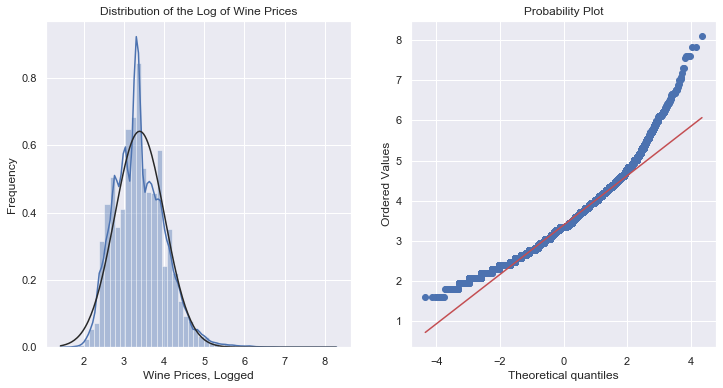

In [37]:
# Plotting a distribution plot, plus a Q-Q plot to check skew
f, (ax1, ax2) = plt.subplots(1,2, figsize=(12,6))

# By setting fit=norm, we can better compare to a normal distribution
sns.distplot(logged_data["log_price"], fit=norm, ax=ax1)
stats.probplot(logged_data["log_price"], plot=ax2)

ax1.set_title("Distribution of the Log of Wine Prices")
ax1.set(xlabel="Wine Prices, Logged", ylabel="Frequency")

plt.show()
# Without removing any outliers, logging the price makes it more normal,
# although it's still skewed. Should be good enough for now, but may want
# to revisit and check outliers later.

In [38]:
# Because the log of price is more normal, for the rest of the analysis we'll
# drop the actual price and our indicator column, price_missing

logged_data.drop(columns=["price", "price_missing"], inplace=True)

In [39]:
# Now, let's deal with our categorical variables
# There are too many unique entries in each of our categorical columns, so
# instead we'll simply label encode each using sklearn

from sklearn.preprocessing import LabelEncoder
labeler = LabelEncoder()

logged_data["country"] = labeler.fit_transform(
    logged_data["country"].astype(str))
logged_data["province"] = labeler.fit_transform(
    logged_data["province"].astype(str))
logged_data["winery"] = labeler.fit_transform(
    logged_data["winery"].astype(str))

# Note! We've done nothing to associate nearby countries with each other
# We'll see how this does, and maybe will have to do some kind of sorting
# later on if this does not produce the results we want
logged_data.head()

,country,points,province,winery,log_price
0,6,87,135,9818,3.332205
1,7,87,48,10908,2.772589
2,9,87,108,10959,2.708050
3,9,87,86,12081,2.639057
4,9,87,108,12271,4.189655


In [40]:
# All of our variables are on VASTLY different scales, so let's scale them 
# all to be between zero and one
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler()
scaled_data = scaler.fit_transform(logged_data)
scaled_data = pd.DataFrame(scaled_data, columns=logged_data.columns)
scaled_data.head()

/anaconda3/lib/python3.7/site-packages/sklearn/preprocessing/data.py:334: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by MinMaxScaler.
  return self.partial_fit(X, y)


,country,points,province,winery,log_price
0,0.666667,0.35,0.767045,0.702490,0.265345
1,0.777778,0.35,0.272727,0.780481,0.179152
2,1.000000,0.35,0.613636,0.784130,0.169211
3,1.000000,0.35,0.488636,0.864410,0.158585
4,1.000000,0.35,0.613636,0.878005,0.397412


In [41]:
scaled_data.describe()

,country,points,province,winery,log_price
count,101085.000000,101085.000000,101085.000000,101085.000000,101085.000000
mean,0.739389,0.427700,0.403967,0.523867,0.274762
std,0.299422,0.155447,0.302563,0.289150,0.095798
min,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.444444,0.300000,0.159091,0.299227,0.205621
50%,0.888889,0.400000,0.215909,0.545578,0.265345
75%,1.000000,0.550000,0.647727,0.774614,0.338423
max,1.000000,1.000000,1.000000,1.000000,1.000000


[]

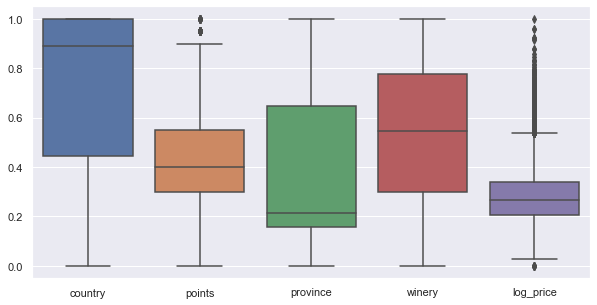

In [42]:
# Checking out the distributions, via boxplots
plt.figure(figsize=(10,5))
sns.boxplot(data=scaled_data)
plt.plot()

In [43]:
# Creating a correlation df to investigate correlation between variables
map_corr = np.corrcoef(scaled_data, rowvar=False)

In [44]:
# Prepping the correlation dataframe to be visualized
map_corr = pd.DataFrame(map_corr,
                        columns=scaled_data.columns,
                        index=scaled_data.columns)

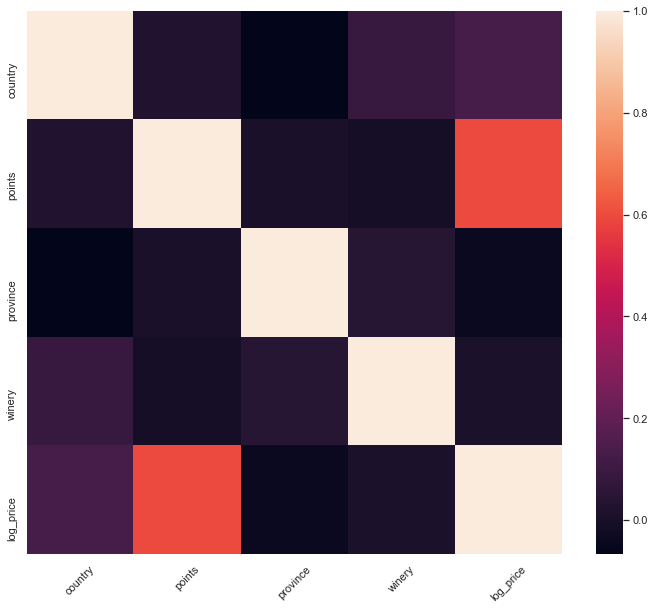

In [45]:
# Plotting the correlation between variables - shouldn't surprise us that 
# price and points are correlated. The rest aren't particularly correlated
plt.figure(figsize=(12,10))
ax = sns.heatmap(data = map_corr)
plt.xticks(rotation=45) 
plt.show()

## Baseline Model

In [46]:
# Here are our two functions so we can check our classification models

# Extra imports, for metrics
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
# unique_label allows the confusion matrix to automatically label itself
from sklearn.utils.multiclass import unique_labels

# Visualizing a confusion matrix
def vis_cm(y_true, y_pred):
    # Takes true values first, then predicted values
    c_mat = confusion_matrix(y_true, y_pred)

    fig, ax = plt.subplots()
    # Visualizes the matrix
    sns.heatmap(c_mat, annot=True, cmap=plt.cm.Blues, fmt='g')

    # Adds title and axis labels
    plt.title('Confusion Matrix')
    plt.ylabel('True Label')
    plt.xlabel('Predicted Label')

    # Adds appropriate axis scales
    class_names = unique_labels(y_true, y_pred)
    tick_marks = np.arange(len(class_names))
    # The +.5 here just centers the labels, red or white, since it's 2x2
    plt.xticks(tick_marks + .5, class_names)
    plt.yticks(tick_marks + .5, class_names)

    plt.show()

def print_scores(model, X_train, X_test, y_train, y_test, y_pred):
    print("Training Accuracy: {}".format(model.score(X_train, y_train)))
    print("Testing Accuracy: {}".format(model.score(X_test, y_test)))
    print(classification_report(y_test, y_pred))

In [47]:
# Need an initial train-test split
X_init_train, X_init_test, y_init_train, y_init_test = train_test_split(
    scaled_data, y, test_size=.25, random_state=543)

Training Accuracy: 0.8353712423990608
Testing Accuracy: 0.790954415954416
              precision    recall  f1-score   support

         red       0.80      0.88      0.84     15739
       white       0.76      0.64      0.70      9533

   micro avg       0.79      0.79      0.79     25272
   macro avg       0.78      0.76      0.77     25272
weighted avg       0.79      0.79      0.79     25272



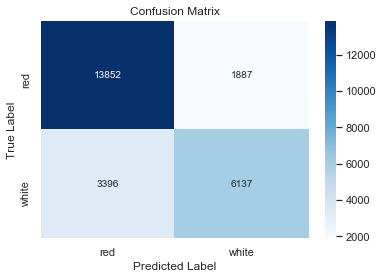

In [48]:
# And now, the XGBoost model we worked out through model selection
import xgboost as xgb

xgb_model = xgb.XGBClassifier(learning_rate=.6,
                              max_depth=6,
                              subsample=1,
                              n_estimators=100,
                              seed=543)
xgb_model.fit(X_init_train, y_init_train)

xgb_model_preds = xgb_model.predict(X_init_test)

print_scores(xgb_model, X_init_train, X_init_test, y_init_train,
             y_init_test, xgb_model_preds)
vis_cm(y_init_test, xgb_model_preds)

## Adding Interactions

Going one step further than what we did when we compared classification models, let's also add in some interaction terms to see if any account for more of the variability in our data.

In [49]:
scaled_data.head()

,country,points,province,winery,log_price
0,0.666667,0.35,0.767045,0.702490,0.265345
1,0.777778,0.35,0.272727,0.780481,0.179152
2,1.000000,0.35,0.613636,0.784130,0.169211
3,1.000000,0.35,0.488636,0.864410,0.158585
4,1.000000,0.35,0.613636,0.878005,0.397412


In [50]:
# Based on our correlation heatmap above, we know that price and points are
# the most highly correlated. Just to visualize, let's add back in our target 
# variable and break down our data by price and points

viz_data = scaled_data.copy()
viz_data["target"] = y
viz_data.head()

,country,points,province,winery,log_price,target
0,0.666667,0.35,0.767045,0.702490,0.265345,white
1,0.777778,0.35,0.272727,0.780481,0.179152,red
2,1.000000,0.35,0.613636,0.784130,0.169211,white
3,1.000000,0.35,0.488636,0.864410,0.158585,white
4,1.000000,0.35,0.613636,0.878005,0.397412,red


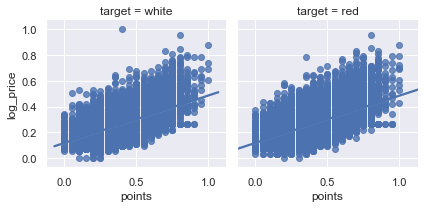

In [51]:
# Now to visualize it
g = sns.FacetGrid(viz_data, col="target") 
g.map(sns.regplot, "points", "log_price") 
plt.show()

<Figure size 576x576 with 0 Axes>

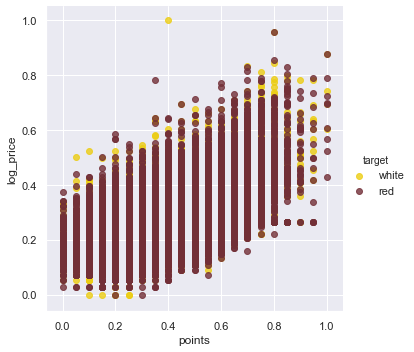

In [52]:
# Another way to visualize it, to see how they overlap
plt.figure(figsize=(8,8))
sns.lmplot(x='points', y='log_price', data=viz_data,
           fit_reg=False, hue='target', palette=["#ECCD13", "#722f37"])
plt.show()

We can absolutely see that price and points are highly correlated - the wine color is almost indistinguishable! But maybe there's something we can do to help our models differentiate.

In [53]:
# Let's add a points/price interaction term as a column
viz_data["points_logprice"] = viz_data["points"] * viz_data["log_price"]
viz_data.head()

,country,points,province,winery,log_price,target,points_logprice
0,0.666667,0.35,0.767045,0.702490,0.265345,white,0.092871
1,0.777778,0.35,0.272727,0.780481,0.179152,red,0.062703
2,1.000000,0.35,0.613636,0.784130,0.169211,white,0.059224
3,1.000000,0.35,0.488636,0.864410,0.158585,white,0.055505
4,1.000000,0.35,0.613636,0.878005,0.397412,red,0.139094


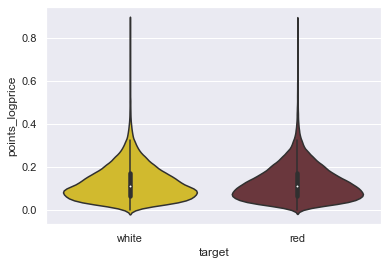

In [54]:
# And now, yet another way to visualize our interaction
sns.violinplot(x='target', y='points_logprice', data=viz_data, 
               palette=["#ECCD13", "#722f37"])

In [59]:
# One last visualization, inspired by https://elitedatascience.com/python-seaborn-tutorial
# Dropping our one interaction term - we'll get back to those in a second
viz_data.drop(columns="points_logprice", inplace=True)

# Going to take a sample of viz_data, since 100,000 data points is a lot
viz_sample = viz_data.sample(n=1000)

# Melting the dataframe to put the visuals together
melted_data = pd.melt(viz_sample,
                      id_vars=["target"],  # Variables to keep
                      var_name="Variables")  # Name of melted variable

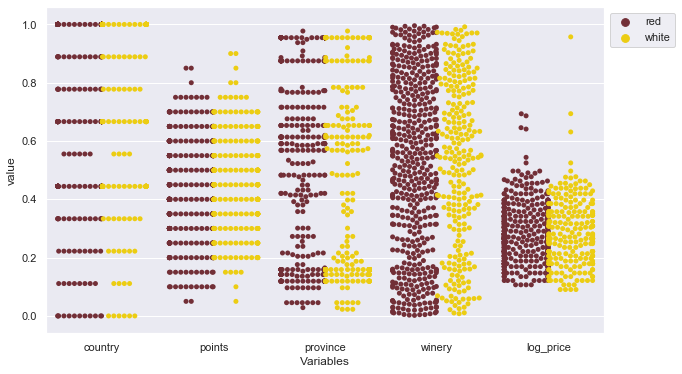

In [63]:
# Plotting a swarmplot of all 5 of our main variables
plt.figure(figsize=(10,6))
sns.swarmplot(x='Variables', y='value', data=melted_data, dodge=True,
              hue='target', palette=["#722f37", "#ECCD13"])
plt.legend(bbox_to_anchor=(1, 1), loc=2)
plt.show()

Pretty easy to see why these models have had trouble differentiating between white and red wines - these are very similar! But perhaps we can do something to change that, maybe there's a magic interaction that helps explain the difference between the two. Let's investigate.

In [ ]:
# Mmkay, let's really work through our data and find useful interaction terms
# This code was inspired by a lab done in learn.co
# More imports
from itertools import combinations
from sklearn.model_selection import cross_val_score

# Setting our baseline, which uses an averaged cross validation score, based
# on xgb_model.score (aka accuracy)
baseline = np.mean(cross_val_score(xgb_model, scaled_data, y, cv=5))
# Getting our list of combinations
combos = list(combinations(scaled_data.columns, 2))

interactions = []

for comb in combos:
    # Setting a new column for each interaction
    scaled_data["interaction"] = scaled_data[comb[0]] * scaled_data[comb[1]]
    # Getting the average score, again based on accuracy
    score = np.mean(cross_val_score(xgb_model, scaled_data, y, cv=5))
    # Grabbing the interaction and score, if it's better than the baseline
    if score > baseline:
        interactions.append((comb[0], comb[1], round(score, 3)))

print("Top 3 interactions: %s" %
      sorted(interactions, key=lambda inter: inter[2], reverse=True)[:3])
# Should get country/winery, province/winery and country/log_price

In [ ]:
# So let's add those top three interactions
inter_data = scaled_data.copy()
inter_data["country_winery"] = inter_data["country"] * inter_data["winery"]
inter_data["province_winery"] = inter_data["province"] * inter_data["winery"]
inter_data["country_logprice"] = inter_data["country"] * inter_data["log_price"]

In [ ]:
# Need a new train/test split to test these interactions

X_inter_train, X_inter_test, y_inter_train, y_inter_test = train_test_split(
    inter_data, y, test_size=.25, random_state=543)

In [ ]:
# Now let's try a new XGBoost model

inter_xgb = xgb.XGBClassifier(learning_rate=.6,
                              max_depth=6,
                              subsample=1,
                              n_estimators=100,
                              seed=543)

inter_xgb.fit(X_inter_train, y_inter_train)
inter_xgb_preds = inter_xgb.predict(X_inter_test)

print_scores(inter_xgb, X_inter_train, X_inter_test, y_inter_train,
             y_inter_test, inter_xgb_preds)
vis_cm(y_inter_test, inter_xgb_preds)

That... did not improve much. Alas.

# Final Thoughts

Some further work that could be done would be to balance out the classes at the very beginning, using a technique like SMOTE. Perhaps synthesizing more white wine data would help differentiate the two classes. 

Another further step would be to do some dimensionality reduction, using a technique like Principal Component Analysis (PCA), to perhaps get a better sense of our data and see if we can detect why our data does not respond well to classification.

Also, remember that we reduced the variability of our data quite a lot in the beginning, by reducing the number of wine varieties we examined and the number of countries those wines were from. Perhaps that reduced our data to the point that the variation a classification model would need to better distinguish between white and red wines.

As I said when working through model selection, there is always the possibility that a 79% testing accuracy is as good as we're going to get with the data we have - you may not be able to predict a wine's color based on where it came from, its price and its score from a sommelier! There is more we can dig into this data set, using techniques like natural language processing, that might be much better uses of this data than what we've arrived at here.